In [1]:
#%pip install yfinance

In [1]:
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt

In [2]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers = ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [3]:
df = getTickerData('btc-usd', 'max', '1d')
df = df.drop(columns={'Volume', 'Adj Close', 'Open', 'High', 'Low'})
df = df.rename(columns={'Close': 'close', 'Date': 'date'})
df['date'] = pd.to_datetime(df['date'])
df

[*********************100%***********************]  1 of 1 completed


,date,close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3140,2023-04-23,27591.384766
3141,2023-04-24,27525.339844
3142,2023-04-25,28307.597656
3143,2023-04-26,28422.701172


In [80]:
rn = random.randint(0, df.value_counts().sum())
i=0

[Timestamp('2015-09-06 00:00:00') 239.83999633789062]


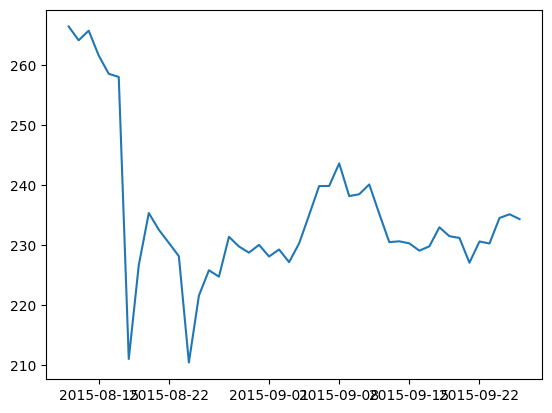

In [103]:
df2 = df.iloc[rn:rn+24+i,:]
final_value = df.iloc[rn+25].values
plt.plot(df2['date'], df2['close'])
print(final_value)
i+=1

In [104]:
class TradingEnv(Env):
    def __init__(self, df, n_steps, analyzation_window_size) -> None:
        super().__init__()
        self.df = df.drop(columns={'date'})
        self.analyzation_window_size = analyzation_window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(analyzation_window_size, self.df.shape[1]))
        self.action_space = Discrete(2)
        self.done = None
        
        self.current_step = 0
        self.n_steps = n_steps
        self.random_index = random.randint(0, df.value_counts().sum())
        
        self.long_pos = []
        self.short_pos = []
        
    def step(self, action):
        
        
        pass
        
    def reset(self):
        self.random_index = random.randint(0, df.value_counts().sum())
        self.done = False
        self.current_step = 0
        return self.get_observation(is_random=True, index=0)
    
    def get_observation(self, is_random, index):
        if is_random:
            self.random_index = random.randint(0, df.value_counts().sum())
        return self.df.iloc[self.random_index:self.random_index+self.analyzation_window_size+index, :].values
    
    def close():
        pass
    
    def render():
        pass

In [106]:
env = TradingEnv(df, analyzation_window_size=90, n_steps=20)

In [113]:
env.reset()

array([[6377.77978516],
       [6388.43994141],
       [6361.25976562],
       [6376.12988281],
       [6419.66015625],
       [6461.00976562],
       [6530.14013672],
       [6453.72021484],
       [6385.62011719],
       [6409.22021484],
       [6411.27001953],
       [6371.27001953],
       [6359.49023438],
       [5738.35009766],
       [5648.02978516],
       [5575.54980469],
       [5554.33007812],
       [5623.54003906],
       [4871.49023438],
       [4451.87011719],
       [4602.16992188],
       [4365.93994141],
       [4347.10986328],
       [3880.76000977],
       [4009.9699707 ],
       [3779.12988281],
       [3820.7199707 ],
       [4257.41992188],
       [4278.84667969],
       [4017.26855469],
       [4214.671875  ],
       [4139.87792969],
       [3894.13085938],
       [3956.89379883],
       [3753.99487305],
       [3521.10180664],
       [3419.93725586],
       [3476.11474609],
       [3614.234375  ],
       [3502.65600586],
       [3424.58813477],
       [3486.950

In [24]:
env.observation_space.sample().shape

(100, 1)